# Code for launching White-box evasion attack on NN for the Mnist Dataset

## Generating the model

### Imports

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import datetime
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
from collections import defaultdict
import scipy as sp
import sklearn
import sklearn.metrics
import itertools
import io

In [17]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


### 1. Create input pipeline

#### Load dataset

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

In [4]:
ds_info

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_path='/Users/danieldelijani/tensorflow_datasets/mnist/3.0.1',
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
)

#### Build a training pipeline

In [5]:
def normalize_img(image, label):
  """Normalizes images: `uint8` -> `float32`."""
  return tf.cast(image, tf.float32) / 255., label

ds_train = ds_train.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(128)
ds_train = ds_train.prefetch(tf.data.AUTOTUNE)

#### Build an evaluation pipeline

In [6]:
ds_test = ds_test.map(
    normalize_img, num_parallel_calls=tf.data.AUTOTUNE)
ds_test = ds_test.batch(128)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(tf.data.AUTOTUNE)

### 2. Create and train the model

Code for confusion martrix

In [7]:
def plot_confusion_matrix(cm, class_names):
    """
    Returns a matplotlib figure containing the plotted confusion matrix.
    
    Args:
       cm (array, shape = [n, n]): a confusion matrix of integer classes
       class_names (array, shape = [n]): String names of the integer classes
    """
    
    figure = plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45)
    plt.yticks(tick_marks, class_names)
    
    # Normalize the confusion matrix.
    cm = np.around(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
    
    # Use white text if squares are dark; otherwise black.
    threshold = cm.max() / 2.
    
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        color = "white" if cm[i, j] > threshold else "black"
        plt.text(j, i, cm[i, j], horizontalalignment="center", color=color)
        
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return figure

def plot_to_image(figure):
    """
    Converts the matplotlib plot specified by 'figure' to a PNG image and
    returns it. The supplied figure is closed and inaccessible after this call.
    """
    
    buf = io.BytesIO()
    
    # Use plt.savefig to save the plot to a PNG in memory.
    plt.savefig(buf, format='png')
    
    # Closing the figure prevents it from being displayed directly inside
    # the notebook.
    plt.close(figure)
    buf.seek(0)
    
    # Use tf.image.decode_png to convert the PNG buffer
    # to a TF image. Make sure you use 4 channels.
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    
    # Use tf.expand_dims to add the batch dimension
    image = tf.expand_dims(image, 0)
    
    return image

def log_confusion_matrix(epoch, logs):
    
    # Use the model to predict the values from the test_images.
    test_pred_raw = model.predict(ds_test)
    
    test_pred = np.argmax(test_pred_raw, axis=1)
    
    test_labels = y = np.concatenate([y for x, y in ds_test], axis=0)
    
    # Calculate the confusion matrix using sklearn.metrics
    cm = sklearn.metrics.confusion_matrix(test_labels, test_pred)
    
    figure = plot_confusion_matrix(cm, class_names=[0,1,2,3,4,5,6,7,8,9])
    cm_image = plot_to_image(figure)
    
    # Log the confusion matrix as an image summary.
    with file_writer_cm.as_default():
        tf.summary.image("Confusion Matrix", cm_image, step=epoch)

Code for model

In [8]:
cm_callback = tf.keras.callbacks.LambdaCallback(on_epoch_end=log_confusion_matrix)

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128),
  tf.keras.layers.Dense(10)
])
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "/model_without_relu"
file_writer_cm = tf.summary.create_file_writer(log_dir + '/cm')
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model.fit(
    ds_train,
    epochs=6,
    validation_data=ds_test,
    callbacks=[tensorboard_callback, cm_callback]
)

Epoch 1/6
469/469 [==============================] - 6s 6ms/step - loss: 0.3937 - sparse_categorical_accuracy: 0.8877 - val_loss: 0.2906 - val_sparse_categorical_accuracy: 0.9206
Epoch 2/6
469/469 [==============================] - 2s 4ms/step - loss: 0.2897 - sparse_categorical_accuracy: 0.9197 - val_loss: 0.2819 - val_sparse_categorical_accuracy: 0.9216
Epoch 3/6
469/469 [==============================] - 2s 5ms/step - loss: 0.2772 - sparse_categorical_accuracy: 0.9234 - val_loss: 0.2754 - val_sparse_categorical_accuracy: 0.9229
Epoch 4/6
469/469 [==============================] - 3s 6ms/step - loss: 0.2708 - sparse_categorical_accuracy: 0.9243 - val_loss: 0.2797 - val_sparse_categorical_accuracy: 0.9226
Epoch 5/6
469/469 [==============================] - 3s 7ms/step - loss: 0.2677 - sparse_categorical_accuracy: 0.9257 - val_loss: 0.2787 - val_sparse_categorical_accuracy: 0.9213
Epoch 6/6
469/469 [==============================] - 3s 6ms/step - loss: 0.2629 - sparse_categorical_accu

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


## Exploring the model

### What input nodes have the most impact?

In [10]:
i = 1
layer = model.layers[i]
weights = model.layers[i].weights[0]
bias = model.layers[i].weights[1]
print(layer.name, layer)
print('weights:', weights)
print('bias:', bias)

dense <keras.layers.core.dense.Dense object at 0x7fdb81634910>
weights: <tf.Variable 'dense/kernel:0' shape=(784, 128) dtype=float32, numpy=
array([[-0.01994492,  0.02526677, -0.04312023, ..., -0.01264462,
        -0.03031058, -0.05941631],
       [ 0.00334713, -0.02425071,  0.04528963, ...,  0.04844252,
        -0.07228647, -0.05070632],
       [ 0.0097158 , -0.00354688,  0.0182943 , ...,  0.01625156,
        -0.04369964, -0.01387374],
       ...,
       [-0.02611777,  0.03296113,  0.03300472, ..., -0.07109509,
        -0.03621043,  0.01667942],
       [ 0.04161131, -0.04313244, -0.03092534, ...,  0.00396317,
         0.07863385, -0.00437856],
       [ 0.08022612, -0.01378782, -0.02967862, ...,  0.01823619,
        -0.04562297,  0.02662132]], dtype=float32)>
bias: <tf.Variable 'dense/bias:0' shape=(128,) dtype=float32, numpy=
array([-0.04683878, -0.24401274, -0.03076126,  0.27436388, -0.02921594,
        0.06507406,  0.21551041, -0.01444369, -0.05353493,  0.14641196,
        0.2230267

In [11]:
sum_of_weights = weights.numpy().sum(axis=1)
sum_of_weights.shape

(784,)

In [12]:
reshaped_weights = np.reshape(sum_of_weights, (28, 28))

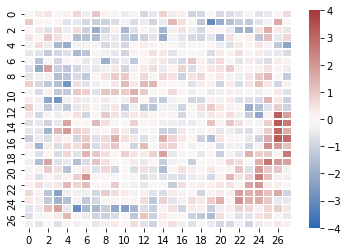

In [13]:
ax = sns.heatmap(reshaped_weights, linewidth=.5, cmap='vlag',vmin = -4, vmax=4)
plt.show()

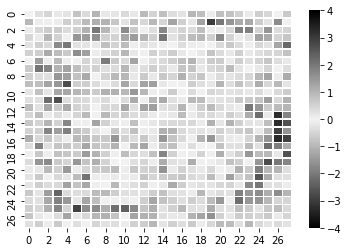

In [14]:
ax = sns.heatmap(reshaped_weights, linewidth=.5, cmap=sns.diverging_palette(0, 0, l=0, as_cmap=True),vmin = -4, vmax=4)
plt.show()

In [15]:
bias

<tf.Variable 'dense/bias:0' shape=(128,) dtype=float32, numpy=
array([-0.04683878, -0.24401274, -0.03076126,  0.27436388, -0.02921594,
        0.06507406,  0.21551041, -0.01444369, -0.05353493,  0.14641196,
        0.22302674,  0.2274384 , -0.05454105, -0.14978948, -0.143539  ,
       -0.1145564 , -0.02431493, -0.05820339,  0.24740134, -0.21964978,
        0.10646845,  0.26469293, -0.04905451,  0.03815816,  0.3108555 ,
        0.03516562, -0.01590764,  0.12539373, -0.18273069, -0.15218475,
       -0.01296476,  0.13019165, -0.00105843,  0.3315362 , -0.13393587,
       -0.17463815, -0.02198197, -0.0427521 ,  0.12945828, -0.13150024,
       -0.15732695, -0.00881325,  0.30975342, -0.1724526 , -0.06656402,
        0.09139692,  0.00156546,  0.22154345, -0.01298934, -0.27567378,
        0.203372  ,  0.0581542 ,  0.1583254 ,  0.00081939,  0.0314742 ,
        0.01583062,  0.14882368,  0.11515793,  0.12320392, -0.04560253,
       -0.14002885, -0.06861421,  0.25381798,  0.07215568, -0.2262471 ,
 

### Tensorboard

In [18]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 13388), started 1 day, 12:33:03 ago. (Use '!kill 13388' to kill it.)